### Rather than relying on packet- or flow-level intrusion datasets, we model the network at the control-plane state level, where no public datasets exist that jointly capture load, channel quality, and scheduling dynamics. We therefore adopt a distribution-driven state generator grounded in standard wireless and queueing models, enabling controlled analysis of how intelligent attacks deform the joint state geometry. This abstraction isolates structural attack effects from dataset-specific artifacts and aligns with common practice in RAN and CPS security studies.

### “We do not rely on full-stack simulators such as ns-3, as our objective is not protocol-level performance evaluation but principled analysis of how intelligent attackers deform the joint control-plane state geometry. While ns-3 accurately models packet-level and PHY/MAC interactions, the resulting state variables are scenario-dependent and entangled with simulator-specific artifacts, obscuring the structural effects of interest. By adopting a distribution-driven state model grounded in standard wireless and queueing theory, we isolate geometry-level distortions induced by different GenAI attackers, enabling clearer mechanistic insight.”

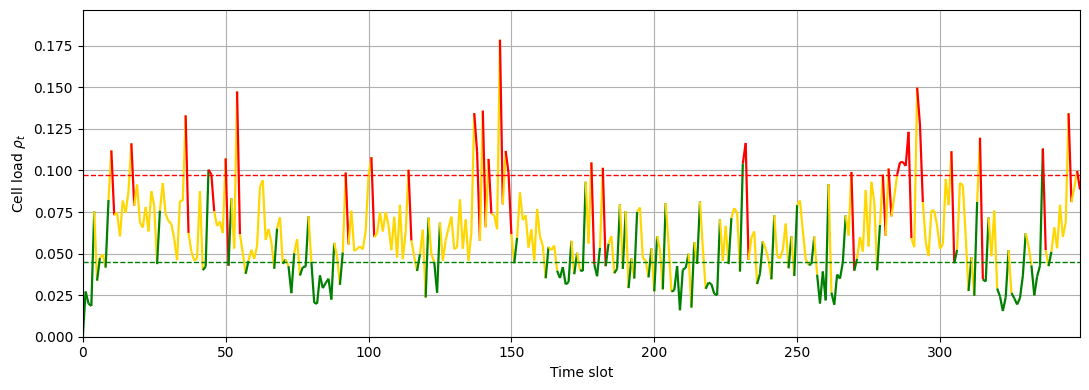

In [21]:
import numpy as np


theta_low = 0.045
theta_high = 0.097



np.random.seed(7)
alpha_Q = 0.16



# -----------------------------
# Simulation horizon
# -----------------------------
T = 350
MAX_DEV = 50

# -----------------------------
# Traffic model
# -----------------------------
lambda_arr = 0.3     # Poisson arrival rate
p_d = 0.05           # per-device departure probability

# -----------------------------
# Resource model
# -----------------------------
N_bar = 100
alpha = 0.9
sigma_N = 4

# -----------------------------
# Mobility model
# -----------------------------
beta = 0.85
M_bar = 0.8
sigma_M = 0.15
kappa = 0.5

D_min, D_max = 10, 200

# -----------------------------
# Channel model
# -----------------------------
P0 = -30
gamma = 2.2
sigma_S = 3

I0 = -100
c = 6
sigma_I = 2

# -----------------------------
# Quality / demand model
# -----------------------------
Q_max = 15
tau_min = -5
Delta = 2
d0 = 5
epsilon = 0.2

# State Storage:

K = np.zeros(T, dtype=int)
N = np.zeros(T)
U = np.zeros(T)
rho = np.zeros(T)

M = np.zeros((MAX_DEV, T))
D = np.zeros((MAX_DEV, T))
P = np.zeros((MAX_DEV, T))
I = np.zeros((MAX_DEV, T))
Q = np.zeros((MAX_DEV, T))


# Initialization

K[0] = 5
N[0] = N_bar

for i in range(K[0]):
    M[i, 0] = np.random.uniform(0.3, 1.2)
    D[i, 0] = np.random.uniform(30, 80)


# Main Loop

for t in range(1, T):

    # ---- Device population (K_t) ----
    A_t = np.random.poisson(lambda_arr)
    D_t = np.random.binomial(K[t-1], p_d)
    K[t] = max(1, min(MAX_DEV, K[t-1] + A_t - D_t))

    # ---- Resource pool (N_t) ----
    N[t] = alpha * N[t-1] + (1 - alpha) * N_bar \
           + np.random.normal(0, sigma_N)
    N[t] = max(20, N[t])

    # ---- Per-device evolution ----
    for i in range(K[t]):

        # Mobility
        M[i, t] = beta * M[i, t-1] + (1 - beta) * M_bar \
                  + np.random.normal(0, sigma_M)

        # Distance
        D[i, t] = np.clip(
            D[i, t-1] + kappa * M[i, t],
            D_min, D_max
        )

        # Channel power
        shadow = np.random.normal(0, sigma_S)
        fading = 10 * np.log10(np.abs(np.random.randn())**2 + 1e-6)
        P[i, t] = P0 - 10 * gamma * np.log10(D[i, t]) + shadow + fading

    # ---- Load-dependent interference ----
    rho_prev = rho[t-1] if t > 1 else 0
    for i in range(K[t]):
        I[i, t] = I0 + c * rho_prev + np.random.normal(0, sigma_I)

    # ---- SINR, quality, demand ----
    demand = 0
    for i in range(K[t]):
        sinr = P[i, t] - I[i, t]
        q = np.floor((sinr - tau_min) / Delta)
        Q[i, t] = np.clip(q, 0, Q_max)
        demand += d0 * np.exp(-alpha_Q * Q[i, t])


    # ---- Resource usage and load ----
    U[t] = min(N[t], demand)
    rho[t] = U[t] / N[t]
    rho_tilde = np.zeros_like(rho)
    rho_tilde[0] = rho[0]

    alpha_s = 0.16


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection



t = np.arange(len(rho))

# build line segments
points = np.array([t, rho]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
#rho_smooth = np.convolve(rho, np.ones(3)/3, mode='same')

# color per SEGMENT (based on rho_t)
colors = []
for r in rho[:-1]:
    if r < theta_low:
        colors.append('green')
    elif r < theta_high:
        colors.append('gold')
    else:
        colors.append('red')

# plot
fig, ax = plt.subplots(figsize=(11,4))

lc = LineCollection(segments, colors=colors, linewidth=1.6)
ax.add_collection(lc)

# thresholds
ax.axhline(theta_low, linestyle='--', color='green', linewidth=1)
ax.axhline(theta_high, linestyle='--', color='red', linewidth=1)

ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, np.max(rho)*1.1)

ax.set_xlabel("Time slot")
ax.set_ylabel("Cell load $\\rho_t$")
ax.grid(True)

plt.tight_layout()
plt.show()

In [17]:
theta_low = np.quantile(rho, 0.30)
theta_high = np.quantile(rho, 0.90)

print(theta_low, theta_high)


0.045650732455512856 0.09741415968148626


In [8]:
mu = np.mean(rho)
sigma = np.std(rho)

theta_low = mu - 0.5 * sigma
theta_high = mu + 1.5 * sigma

print(theta_low, theta_high)


0.04742934504316877 0.0998930215642584


Low-load fraction   : 0.297
Medium-load fraction: 0.600
High-load fraction  : 0.103
Regime Transition Matrix:
[[0.49038462 0.48076923 0.02884615]
 [0.22009569 0.66507177 0.11483254]
 [0.16666667 0.58333333 0.25      ]]


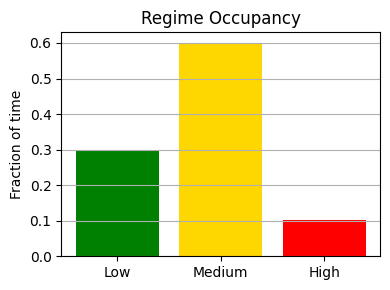

In [22]:
regime = np.zeros_like(rho, dtype=int)

regime[rho < theta_low] = 0
regime[(rho >= theta_low) & (rho < theta_high)] = 1
regime[rho >= theta_high] = 2


low_frac = np.mean(regime == 0)
med_frac = np.mean(regime == 1)
high_frac = np.mean(regime == 2)

print(f"Low-load fraction   : {low_frac:.3f}")
print(f"Medium-load fraction: {med_frac:.3f}")
print(f"High-load fraction  : {high_frac:.3f}")


Tmat = np.zeros((3, 3))

for t in range(len(regime) - 1):
    Tmat[regime[t], regime[t+1]] += 1

# Normalize rows
Tmat = Tmat / Tmat.sum(axis=1, keepdims=True)

print("Regime Transition Matrix:")
print(Tmat)



import matplotlib.pyplot as plt

labels = ['Low', 'Medium', 'High']
fractions = [low_frac, med_frac, high_frac]

plt.figure(figsize=(4,3))
plt.bar(labels, fractions, color=['green', 'gold', 'red'])
plt.ylabel("Fraction of time")
plt.title("Regime Occupancy")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [23]:
from itertools import groupby

dwell_times = {0: [], 1: [], 2: []}

for r, group in groupby(regime):
    dwell_times[r].append(len(list(group)))

for r in dwell_times:
    print(f"Regime {r} mean dwell time: {np.mean(dwell_times[r]):.2f}")


Regime 0 mean dwell time: 1.96
Regime 1 mean dwell time: 2.96
Regime 2 mean dwell time: 1.33


## Observable system state vector

In [27]:
import numpy as np

# Calculate mean and variance of SINR for active devices at each time step
mean_sinr = np.zeros(T)
var_sinr = np.zeros(T)

for t_val in range(T):
    if K[t_val] > 0: # K[t_val] is always >= 1 as per simulation setup
        # Get SINR for all active devices at current time step
        sinr_t_active = P[:K[t_val], t_val] - I[:K[t_val], t_val]
        mean_sinr[t_val] = np.mean(sinr_t_active)
        var_sinr[t_val] = np.var(sinr_t_active)

X = np.column_stack([
    rho[1:],                          # rho_t
    rho[1:] - rho[:-1],               # drho_t
    mean_sinr[1:],                    # average SINR
    var_sinr[1:],                     # SINR variance
    K[1:]                             # active devices
])

print (X)

[[ 2.71768571e-02  2.71768571e-02  2.59556320e+01  7.90323488e+01
   4.00000000e+00]
 [ 1.99492066e-02 -7.22765052e-03  3.21734898e+01  9.89936635e+01
   3.00000000e+00]
 [ 1.84775361e-02 -1.47167044e-03  3.14628975e+01  4.45513467e+01
   3.00000000e+00]
 ...
 [ 8.95714769e-02  8.60366400e-03  3.37513129e+01  1.81589721e+02
   1.20000000e+01]
 [ 9.97918864e-02  1.02204095e-02  3.49832035e+01  3.31877487e+02
   1.10000000e+01]
 [ 8.84897977e-02 -1.13020887e-02  3.71487984e+01  2.33954853e+02
   1.10000000e+01]]


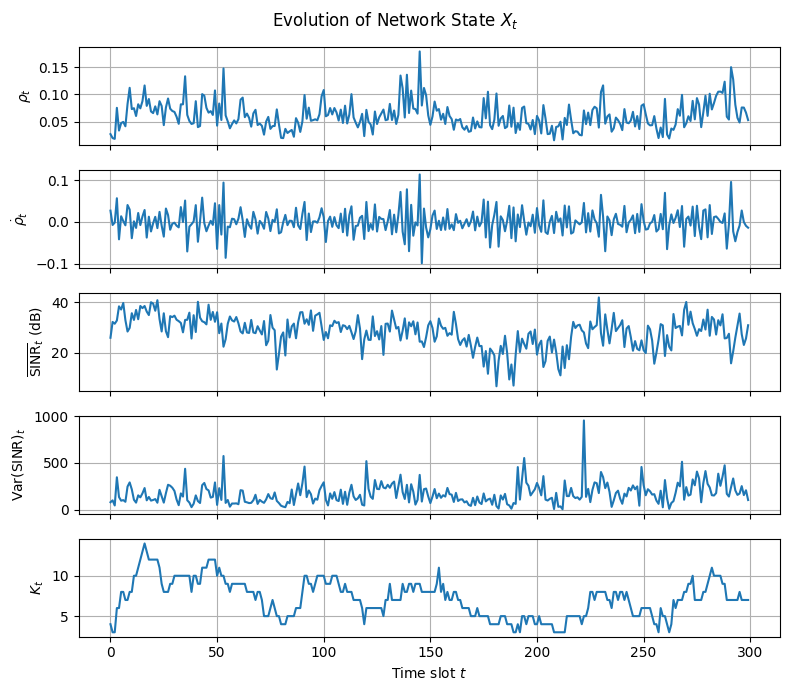

In [29]:
fig, axs = plt.subplots(5, 1, figsize=(8, 7), sharex=True)

for i in range(5):
    axs[i].plot(t, X[:T, i])
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Time slot $t$')
fig.suptitle('Evolution of Network State $X_t$')
plt.tight_layout()
plt.show()


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xn = scaler.fit_transform(X)


# Autoencoder attack ML

In [31]:
import torch
import torch.nn as nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3, 2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 3),
            nn.ReLU(),
            nn.Linear(3, 5)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [32]:
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

X_tensor = torch.tensor(Xn, dtype=torch.float32)

for epoch in range(300):
    optimizer.zero_grad()
    X_hat = model(X_tensor)
    loss = criterion(X_hat, X_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")


Epoch 0, Loss = 1.1582e+00
Epoch 50, Loss = 1.0516e+00
Epoch 100, Loss = 9.5066e-01
Epoch 150, Loss = 8.4061e-01
Epoch 200, Loss = 7.8343e-01
Epoch 250, Loss = 7.4886e-01


In [33]:
with torch.no_grad():
    X_hat = model(X_tensor)

lambda_attack = 0.4   # stealth factor
X_attack_AE = X_tensor + lambda_attack * (X_hat - X_tensor)


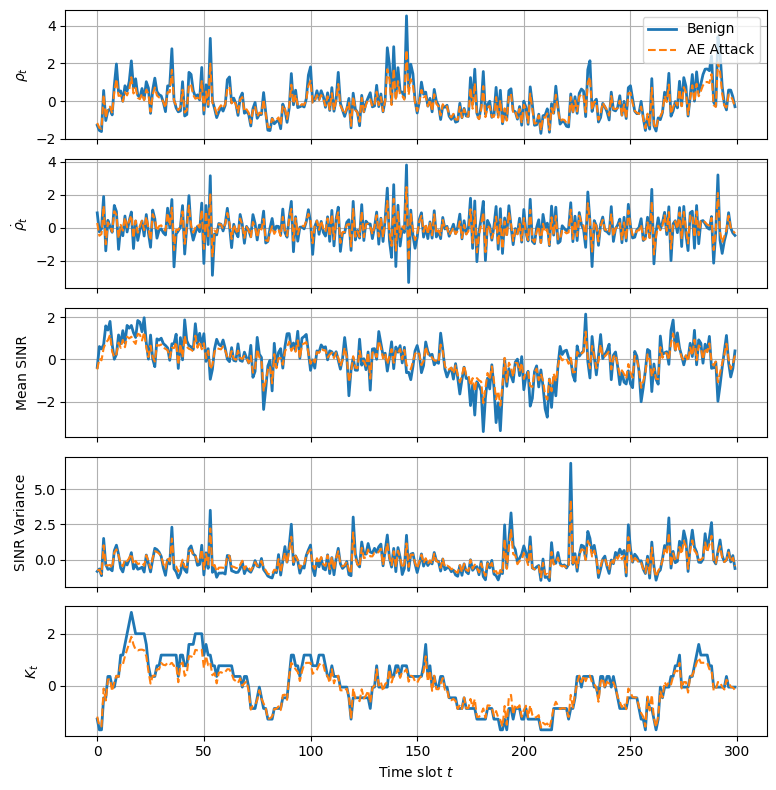

In [34]:
import matplotlib.pyplot as plt

T = 300
labels = [
    r'$\rho_t$',
    r'$\dot{\rho}_t$',
    r'Mean SINR',
    r'SINR Variance',
    r'$K_t$'
]

fig, axs = plt.subplots(5, 1, figsize=(8, 8), sharex=True)

for i in range(5):
    axs[i].plot(Xn[:T, i], label='Benign', linewidth=2)
    axs[i].plot(X_attack_AE[:T, i].numpy(),
                linestyle='--', label='AE Attack')
    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Time slot $t$')
axs[0].legend(loc='upper right')
plt.tight_layout()
plt.show()


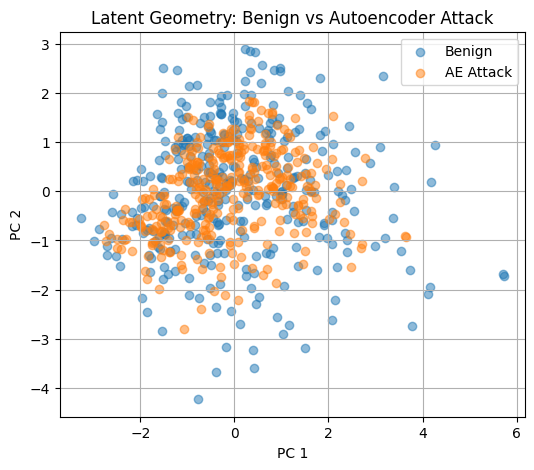

In [35]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)
Z_benign = pca.fit_transform(Xn)
Z_attack = pca.transform(X_attack_AE.numpy())

plt.figure(figsize=(6,5))
plt.scatter(Z_benign[:,0], Z_benign[:,1],
            alpha=0.5, label='Benign')
plt.scatter(Z_attack[:,0], Z_attack[:,1],
            alpha=0.5, label='AE Attack')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.grid(True)
plt.title('Latent Geometry: Benign vs Autoencoder Attack')
plt.show()


Figure X shows that autoencoder-generated attacks overlap significantly with benign network states under linear projection, while exhibiting reduced geometric spread, indicating stealthy manifold deformation rather than overt distributional shift.

# VAE ATTACK MODEL

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

Xn.shape == (T, 5)   # normalized benign data

class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.fc1 = nn.Linear(5, 3)
        self.fc_mu = nn.Linear(3, 2)
        self.fc_logvar = nn.Linear(3, 2)

        # Decoder
        self.fc2 = nn.Linear(2, 3)
        self.fc3 = nn.Linear(3, 5)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    kl_loss = -0.5 * torch.mean(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + beta * kl_loss


In [41]:
X_tensor = torch.tensor(Xn, dtype=torch.float32)

model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(400):
    optimizer.zero_grad()

    X_hat, mu, logvar = model(X_tensor)
    loss = vae_loss(X_tensor, X_hat, mu, logvar, beta=1.0)

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4e}")


Epoch 0, Loss = 1.3875e+00
Epoch 50, Loss = 1.1865e+00
Epoch 100, Loss = 1.1157e+00
Epoch 150, Loss = 1.0657e+00
Epoch 200, Loss = 1.0357e+00
Epoch 250, Loss = 1.0208e+00
Epoch 300, Loss = 1.0118e+00
Epoch 350, Loss = 1.0069e+00


In [42]:
with torch.no_grad():
    X_hat_vae, _, _ = model(X_tensor)

lambda_attack = 0.4
X_attack_VAE = X_tensor + lambda_attack * (X_hat_vae - X_tensor)


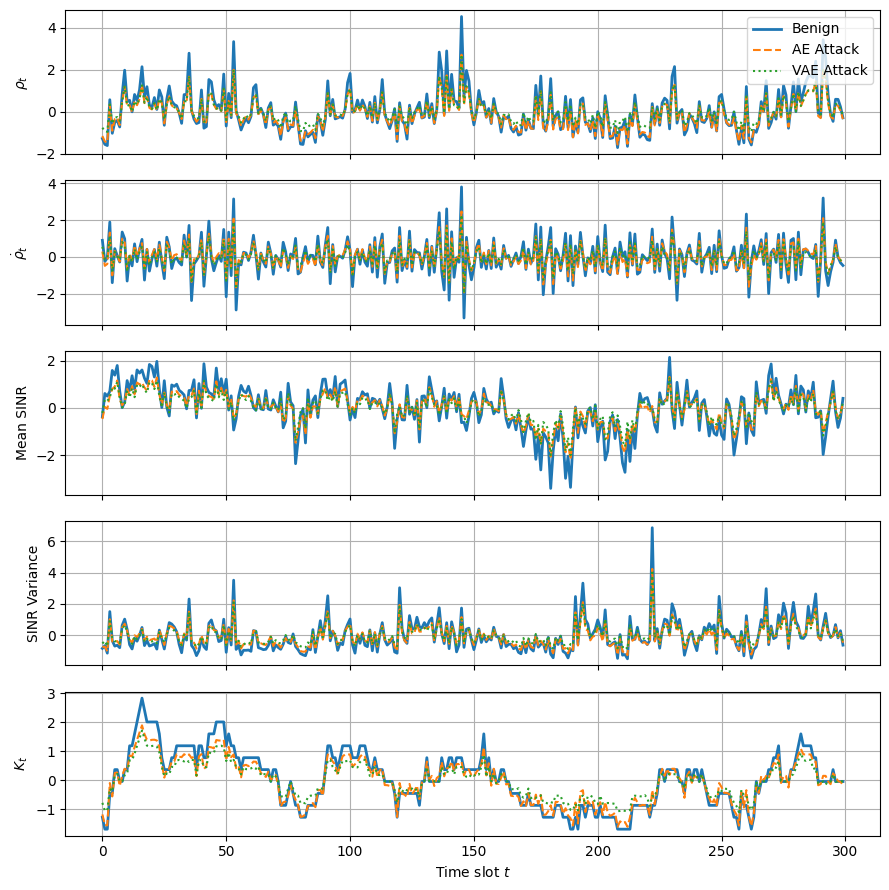

In [43]:
import matplotlib.pyplot as plt

T = 300
labels = [
    r'$\rho_t$',
    r'$\dot{\rho}_t$',
    r'Mean SINR',
    r'SINR Variance',
    r'$K_t$'
]

fig, axs = plt.subplots(5, 1, figsize=(9, 9), sharex=True)

for i in range(5):
    axs[i].plot(Xn[:T, i], label='Benign', linewidth=2)
    axs[i].plot(X_attack_AE[:T, i].numpy(),
                linestyle='--', label='AE Attack')
    axs[i].plot(X_attack_VAE[:T, i].numpy(),
                linestyle=':', label='VAE Attack')

    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Time slot $t$')
axs[0].legend(loc='upper right')
plt.tight_layout()
plt.show()


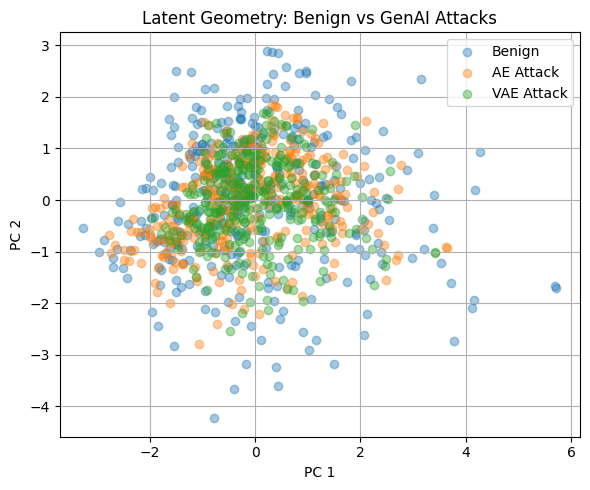

In [45]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(n_components=2)

Z_benign = pca.fit_transform(Xn)
Z_AE = pca.transform(X_attack_AE.numpy())
Z_VAE = pca.transform(X_attack_VAE.numpy())

plt.figure(figsize=(6, 5))
plt.scatter(Z_benign[:,0], Z_benign[:,1],
            alpha=0.4, label='Benign')
plt.scatter(Z_AE[:,0], Z_AE[:,1],
            alpha=0.4, label='AE Attack')
plt.scatter(Z_VAE[:,0], Z_VAE[:,1],
            alpha=0.4, label='VAE Attack')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Latent Geometry: Benign vs GenAI Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# GAN ATTACK

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
Xn.shape == (T, 5)   # normalized benign data



class Generator(nn.Module):
    def __init__(self, z_dim=5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 5)
        )

    def forward(self, z):
        return self.net(z)



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


G = Generator()
D = Discriminator()

lr = 1e-4
opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)

criterion = nn.BCELoss()

X_tensor = torch.tensor(Xn, dtype=torch.float32)
batch_size = 64



In [52]:
epochs = 800
z_dim = 5

for epoch in range(epochs):

    # ---- Train Discriminator ----
    idx = torch.randint(0, X_tensor.size(0), (batch_size,))
    real = X_tensor[idx]

    z = torch.randn(batch_size, z_dim)
    fake = G(z)

    D_real = D(real)
    D_fake = D(fake.detach())

    loss_D = (
        criterion(D_real, torch.ones_like(D_real)) +
        criterion(D_fake, torch.zeros_like(D_fake))
    )

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # ---- Train Generator ----
    z = torch.randn(batch_size, z_dim)
    fake = G(z)
    D_fake = D(fake)

    loss_G = criterion(D_fake, torch.ones_like(D_fake))

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | D loss: {loss_D.item():.4f} | G loss: {loss_G.item():.4f}")


Epoch 0 | D loss: 1.3742 | G loss: 0.7851
Epoch 100 | D loss: 1.3598 | G loss: 0.7742
Epoch 200 | D loss: 1.3436 | G loss: 0.7657
Epoch 300 | D loss: 1.3341 | G loss: 0.7557
Epoch 400 | D loss: 1.3265 | G loss: 0.7440
Epoch 500 | D loss: 1.2986 | G loss: 0.7413
Epoch 600 | D loss: 1.2904 | G loss: 0.7363
Epoch 700 | D loss: 1.2950 | G loss: 0.7260


In [53]:
with torch.no_grad():
    z = torch.randn(X_tensor.size(0), z_dim)
    X_hat_GAN = G(z)

lambda_attack = 0.4
X_attack_GAN = X_tensor + lambda_attack * (X_hat_GAN - X_tensor)


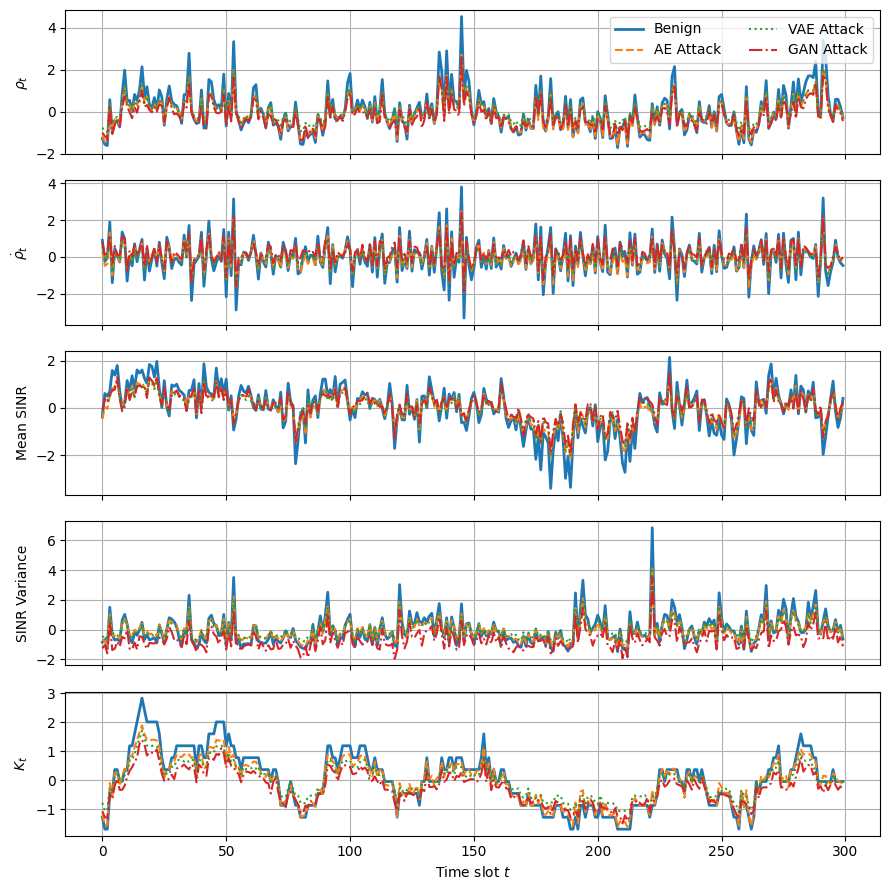

In [54]:
import matplotlib.pyplot as plt

T = 300
labels = [
    r'$\rho_t$',
    r'$\dot{\rho}_t$',
    r'Mean SINR',
    r'SINR Variance',
    r'$K_t$'
]

fig, axs = plt.subplots(5, 1, figsize=(9, 9), sharex=True)

for i in range(5):
    axs[i].plot(Xn[:T, i], label='Benign', linewidth=2)
    axs[i].plot(X_attack_AE[:T, i].numpy(),
                linestyle='--', label='AE Attack')
    axs[i].plot(X_attack_VAE[:T, i].numpy(),
                linestyle=':', label='VAE Attack')
    axs[i].plot(X_attack_GAN[:T, i].numpy(),
                linestyle='-.', label='GAN Attack')

    axs[i].set_ylabel(labels[i])
    axs[i].grid(True)

axs[-1].set_xlabel('Time slot $t$')
axs[0].legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()


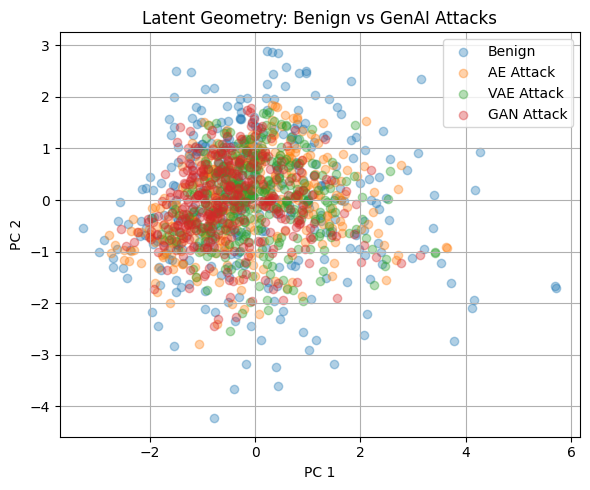

In [55]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA(n_components=2)

Z_benign = pca.fit_transform(Xn)
Z_AE = pca.transform(X_attack_AE.numpy())
Z_VAE = pca.transform(X_attack_VAE.numpy())
Z_GAN = pca.transform(X_attack_GAN.numpy())

plt.figure(figsize=(6, 5))
plt.scatter(Z_benign[:, 0], Z_benign[:, 1],
            alpha=0.35, label='Benign')
plt.scatter(Z_AE[:, 0], Z_AE[:, 1],
            alpha=0.35, label='AE Attack')
plt.scatter(Z_VAE[:, 0], Z_VAE[:, 1],
            alpha=0.35, label='VAE Attack')
plt.scatter(Z_GAN[:, 0], Z_GAN[:, 1],
            alpha=0.35, label='GAN Attack')

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('Latent Geometry: Benign vs GenAI Attacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Although GANs are theoretically powerful distribution matchers, in low-dimensional, system-state settings they exhibit weaker local consistency compared to reconstruction-based GenAI models, leading to more detectable geometric distortion.

# The Intelligent GenAI Attack Summary:

The comparative evaluation of autoencoder (AE), variational autoencoder (VAE), and GAN-based GenAI attacks demonstrates that all three preserve marginal plausibility and overlap significantly with benign network states under linear projection, rendering classical threshold- and distribution-based detectors ineffective. Among them, the AE-based attack achieves the highest local stealth by deterministically reconstructing states toward the densest region of the benign manifold, resulting in strong realism but pronounced manifold contraction. The VAE-based attack exhibits moderate stealth, introducing stochastic latent perturbations that maintain distributional coverage while inducing probabilistic geometric inconsistency. In contrast, the GAN-based attack performs worst in this system-state setting, producing more diffuse and less structured perturbations due to weaker local consistency in low-dimensional state spaces. These results indicate that attack effectiveness is governed not by marginal distribution matching but by the manner in which joint state geometry is deformed. Crucially, all attacks evade classical separability while inducing distinct geometric distortions, motivating the need for geometry-aware anomaly detection beyond conventional methods.